# Revtsov Final Project

### Imports

In [167]:
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.stats import norm, zscore, qmc
import time
import polars as pl
import itertools

import matplotlib.pyplot as plt
idx = pd.IndexSlice

### Inputs
The next few blocks of code set up inputs such as
- fund allocations
- asset class risk and returns
- assst class correlation and covariance matrices
- client input information

In [142]:
asset_classes = ['US Equity', 'DM ex-US Equity', 'EM Equity', 'REIT', 'US Bonds', 'Hedge Funds', 'Cash']
funds = [f'Mix{i}' for i in range(1, 9)]
client_names = ['Amy Abrams', 'Bob Brown', 'Carla Clausen', 'Darrin Dorne', 'Eric Evans', 'Francine Farnsworth']

In [4]:
fund_wts = pd.DataFrame(
    index=asset_classes,
    columns=funds,
    data=[
        [.30, .25, .25, .23, .21, .16, .13, .08],
        [.30, .25, .21, .19, .15, .12, .09, .06],
        [.10, .10, .08, .06, .04, .04, .02, .01],
        [.10, .10, .08, .06, .05, .04, .03, .02],
        [.10, .20, .30, .40, .45, .50, .55, .51],
        [.10, .10, .08, .06, .05, .04, .03, .02],
        [.00, .00, .00, .00, .05, .10, .15, .30],
    ],
)
fund_wts.mul(100)

,Mix1,Mix2,Mix3,Mix4,Mix5,Mix6,Mix7,Mix8
US Equity,30.0,25.0,25.0,23.0,21.0,16.0,13.0,8.0
DM ex-US Equity,30.0,25.0,21.0,19.0,15.0,12.0,9.0,6.0
EM Equity,10.0,10.0,8.0,6.0,4.0,4.0,2.0,1.0
REIT,10.0,10.0,8.0,6.0,5.0,4.0,3.0,2.0
US Bonds,10.0,20.0,30.0,40.0,45.0,50.0,55.0,51.0
Hedge Funds,10.0,10.0,8.0,6.0,5.0,4.0,3.0,2.0
Cash,0.0,0.0,0.0,0.0,5.0,10.0,15.0,30.0


In [5]:
asset_class_stats = pd.DataFrame(
    index=asset_classes, 
    columns=['Return', 'Risk'],
    data=[
        [.060, .191],
        [.059, .202],
        [.070, .268],
        [.056, .207],
        [.019, .038],
        [.052, .070],
        [.015, .058],
    ],
)
asset_class_stats.mul(100)

,Return,Risk
US Equity,6.0,19.1
DM ex-US Equity,5.9,20.2
EM Equity,7.0,26.8
REIT,5.6,20.7
US Bonds,1.9,3.8
Hedge Funds,5.2,7.0
Cash,1.5,5.8


In [6]:
asset_class_corr = pd.DataFrame(
    index=asset_classes,
    columns=asset_classes,
    data=[
        [1.00] + [0]*6,
        [0.74, 1.00] + [0]*5,
        [0.67, 0.70, 1.00] + [0]*4,
        [0.74, 0.78, 0.66, 1.00] + [0]*3,
        [0.13, 0.09, 0.07, 0.10, 1.00] + [0]*2,
        [0.47, 0.46, 0.45, 0.37, 0.10, 1.00, 0.00],
        [0.02, 0.00, -0.03, -0.03, 0.10, 0.55, 1.00],
    ],
)
asset_class_corr = asset_class_corr + np.tril(asset_class_corr, k=-1).T
asset_class_corr

,US Equity,DM ex-US Equity,EM Equity,REIT,US Bonds,Hedge Funds,Cash
US Equity,1.00,0.74,0.67,0.74,0.13,0.47,0.02
DM ex-US Equity,0.74,1.00,0.70,0.78,0.09,0.46,0.00
EM Equity,0.67,0.70,1.00,0.66,0.07,0.45,-0.03
REIT,0.74,0.78,0.66,1.00,0.10,0.37,-0.03
US Bonds,0.13,0.09,0.07,0.10,1.00,0.10,0.10
Hedge Funds,0.47,0.46,0.45,0.37,0.10,1.00,0.55
Cash,0.02,0.00,-0.03,-0.03,0.10,0.55,1.00


In [7]:
asset_class_covar = asset_class_stats.Risk.mul(asset_class_corr).mul(asset_class_stats.Risk, axis=0)
asset_class_covar

,US Equity,DM ex-US Equity,EM Equity,REIT,US Bonds,Hedge Funds,Cash
US Equity,0.036481,0.028551,0.034296,0.029257,0.000944,0.006284,0.000222
DM ex-US Equity,0.028551,0.040804,0.037895,0.032615,0.000691,0.006504,0.000000
EM Equity,0.034296,0.037895,0.071824,0.036614,0.000713,0.008442,-0.000466
REIT,0.029257,0.032615,0.036614,0.042849,0.000787,0.005361,-0.000360
US Bonds,0.000944,0.000691,0.000713,0.000787,0.001444,0.000266,0.000220
Hedge Funds,0.006284,0.006504,0.008442,0.005361,0.000266,0.004900,0.002233
Cash,0.000222,0.000000,-0.000466,-0.000360,0.000220,0.002233,0.003364


In [143]:
clients = pd.DataFrame(
    index=client_names,
    columns=['Age', 'CurrentValue'],
    data=[
        [52, 500],
        [55, 400],
        [57, 900],
        [57, 500],
        [62, 1100],
        [65, 950],
    ],
)
clients

,Age,CurrentValue
Amy Abrams,52,500
Bob Brown,55,400
Carla Clausen,57,900
Darrin Dorne,57,500
Eric Evans,62,1100
Francine Farnsworth,65,950


### Setup Calculations 
Target Wealth, IRR Calculation

In [10]:
retirement_age = 67
savings_rate = 0.16

In [242]:
def calc_salary(age):
    # calculate salary given the input formula
    return 60 + (np.minimum(age, 66) - 27)

In [243]:
def calc_irr(cf, horizon, tgt, min_bound, max_bound, guess=None, tol=1e-2):
    """
    Calculate the Constant Rate of Return or IRR
    cf: cash flows
    horizon: investment horizon for each cash flow
    tgt: overall target wealth
    min_bound: minimum bound for choosing return
    max_bound: maximum bound for choosing return
    guess: initial guess
    tol: tolerance of the target wealth (stop iterating if wealth achived using proposed return is less than tol away from target)
    
    The approach is to take a large initial guess at the return number and calculte the final wealth given cash flows and investment horizons
        - if too high, decrease the max bound
        - if too low, incrase the min bound
    Call the function recursively until calculated wealth is within tolerance
    """
    if guess is None:
        guess = (tgt / cf[0]) ** (1/horizon[0]) - 1
    # print(guess)
    proposed = np.sum(cf * ((1+guess) ** horizon))
    diff = proposed - tgt
    if diff > 0 and abs(diff) > tol:
        # if proposed is larger than target, guess is the new max bound
        return calc_irr(cf, horizon, tgt=tgt, min_bound=min_bound, max_bound=guess, guess=(guess+min_bound)/2, tol=tol)
    elif diff < 0 and abs(diff) > tol:
        # if proposed is smaller than target, guess is the new min bound
        return calc_irr(cf, horizon, tgt=tgt, min_bound=guess, max_bound=max_bound, guess=(guess+max_bound)/2, tol=tol)
    else:
        return guess

In [14]:
# the salary right before retirement is the same salary as the previous year
# as discussed in class, since the employee is about to retire they do not receive a raise
pre_retirement_salary = calc_salary(retirement_age-1)

In [15]:
# since the post-retirement annual spend will be 80% of the pre-retirement income and Social Security
# covers 30% of that (30% of the pre-retirement income not of post-retirement spend)
# the portfolio withdrawals will be 50% of pre-retirement income
retirement_annual_spend = pre_retirement_salary * 0.5
target_wealth = retirement_annual_spend / 0.035
print(f'Target wealth is {round(target_wealth, 1)}K')

Target wealth is 1414.3K


#### Fund Expected Stats
Calculate the fund expected risk and return given allocation and asset class expected return and covariance

In [9]:
fund_stats = pd.DataFrame(
    index=fund_wts.columns,
    columns=['Return', 'Risk'],
)
for f in fund_stats.index:
    fund_stats.loc[f, 'Return'] = fund_wts[f] @ asset_class_stats['Return']
    fund_stats.loc[f, 'Risk'] = (fund_wts[f] @ asset_class_covar @ fund_wts[f])** (1/2)
fund_stats

,Return,Risk
Mix1,0.0554,0.152505
Mix2,0.05135,0.135047
Mix3,0.04733,0.119634
Mix4,0.04329,0.104735
Mix5,0.03895,0.088309
Mix6,0.0348,0.073098
Mix7,0.03045,0.05813
Mix8,0.02539,0.04399


#### Cash Flows
Calculate the annual cashflows from the client and their employer matching

In [225]:
age_vector = np.array(range(52, retirement_age))
cf_uniform = pd.Series(index=age_vector, data=calc_salary(age_vector) * savings_rate)

### Explanation

#### What are we trying to achive?
- Determine the investment plan to maximize each client's utility at retirement.
- In simple terms, "utility" here means the client's happiness for each level of wealth.

#### Inputs
##### Client
- Current age/retirement age
- Current portfolio value
- Future contributions
- Desired disbursements past retirement
##### Funds
- 8 funds available with differerent allocations
- each fund has a different risk+return profile.
- Mix 1 is the most aggressive and Mix 8 most defensive.

#### Conceptual Problem Setup
- This is a stochastic dynamic programming problem. What exactly does this mean?
    - "Stochastic" means we are dealing with randomness. We can have expectations of the market but cannot exactly predict what happens. Therefore we need to create scenarios for different outcomes.
    - "Dynamic programming" means there are multiple stages to the problem where a decision can be made. This is because we are able to make allocation decisions on an annual basis.
- Stages, states, decision ariables, objective


#### Solution Approach

##### Calculate Utility for each level of Wealth
- we can look up the utility instead of re-calculating it
- determine the min/max wealth levels at each age
    - i ran a single model w/ precision of 1k and wide bounds  
##### Calculate Expected Utility for Age/Wealth Combo
- Given age A, fund F, and wealth W, determine the possible W_1 values.
- These outcomes depend on starting wealth (W+CF) and return characteristics (mean, stdev) of the fund
- Based on those outcomes calculate the expected utility
- Decision goes to the fund with the biggest expected utility
##### Determine investment plan
- Starting at current age and wealth, choose the fund w/ highest utility.
- Based on that fund's expected return and additional cashflow, determine the expected wealth for T+1.
- Repeat each year until retirement.
##### Give possible outcomes of plan
- confidence cone for each client
- how to define "market out/under performs"? ok to just give results in confidence intervals?
### How did I test/confirm solution
- comparison to constant rate of return
- also - the calculated constant rate of return gives a good gauge:
    - likelyhood of meeting goal
    - investment plan 

### Investment Plan Calculation

In [244]:
def calc_utility(tgt: float, x: np.array, gamma:float=0.02):
    """
    Function to calculate utility based on given utility function.
        tgt: target wealth
        x: vector or matrix of wealth levels for which to calculate utility
        gamma: risk aversion
    Important feature is it can take in a matrix of wealth values and calculate utility vectorized
    """
    u = np.zeros(x.shape)

    mask_gt = x > 1.2*tgt
    u[mask_gt] = (1.2*tgt)**(0.2)*(x[mask_gt])**0.8

    mask_lt = x < 0.8*tgt
    # u[mask_lt] = 0.08 + 0.9*x[mask_lt] - gamma*(1.2-0.8)**2 * tgt**2
    u[mask_lt] = -15840 + 15*x[mask_lt] - gamma*(1.2-0.8)**2*tgt**2
    
    mask = (~mask_gt) & (~mask_lt)
    u[mask] = x[mask] - gamma * (1.2*tgt-x[mask])**2
    
    return u

In [245]:
# drives the precision of utility and expected utility cals
PRECISION = 100
# significant digits for rounding since everything is in thousands
SIG_DIGITS = int(np.abs(np.log10(PRECISION/1000)))
# range of outcomes to analyze when taking the distribution
N_SIGMA = 3

In [247]:
# determine the min and max values of wealth for which to calculate expected utility each year
min_r = fund_stats.loc['Mix8', 'Return']
max_r = fund_stats.loc['Mix1', 'Return']
max_sigma = fund_stats.loc['Mix1', 'Risk']

# i determine the wealth bounds by considering the wealth target expectations and out/under performing by 4 standard deviations 
# of the most aggressive fund offered
wealth_bounds = pd.DataFrame(index=np.array(range(retirement_age, retirement_age - 16, -1)), columns=['min_wealth', 'max_wealth'])
wealth_bounds['min_wealth'] = -min_r
wealth_bounds['max_wealth'] = -min_r
wealth_bounds.loc[67] = [1 + max_r - (max_sigma*4), 1 + max_r + (max_sigma*4)]
wealth_bounds = wealth_bounds.cumsum().mul(target_wealth).round(SIG_DIGITS).sort_index(ascending=True)
wealth_bounds.index.name = 'age'

In [246]:
# calculate the number of observations we need to produce to calculate utility of wealth
n = int((wealth_bounds.loc[67, 'max_wealth'] - wealth_bounds.loc[52, 'min_wealth']) * (1000/PRECISION) +1)

final_wealth = np.round(np.linspace(wealth_bounds.loc[52, 'min_wealth'], wealth_bounds.loc[67, 'max_wealth'], num=n), 3)
util = calc_utility(tgt=target_wealth, x=final_wealth)
wealth_util = pd.Series(index=final_wealth, data=util, name='utility')
wealth_util.index.name = 'wealth'

In [22]:
r_all = fund_stats.loc[:, 'Return'].values
sigma_all = fund_stats.loc[:, 'Risk'].values

In [248]:
def calc_expected_utility_vectorized(w_0: float, cf_0: float, r_0: np.array, sigma_0: np.array):
    """
    Calculate the expected utility. This function can calculate the expected utility
    of multiple funds at once using the same distribution of events.
        w_0: starting wealth
        cf_0: beginning of period cash flow
        r_0: expected return of funds for which to calculate expected utility
        sigma_0: expected standard deviation of funds
    """
    # determine how many samples to generate
    rounding_multiplier = (1000/PRECISION)
    w_1_max = np.ceil((w_0 + cf_0) * (1+(r_0+(sigma_0*N_SIGMA))) * rounding_multiplier)/rounding_multiplier
    w_1_min = np.floor((w_0 + cf_0) * (1+(r_0-(sigma_0*N_SIGMA))) * rounding_multiplier)/rounding_multiplier    
    num = int((w_1_max.max() - w_1_min.min()) * 10**(SIG_DIGITS))
    # take samples using given min max
    samples = np.linspace(start=-1*N_SIGMA, stop=N_SIGMA, num=num)
    # adjust the sample mean
    samples = samples - samples.mean()

    # calculate cdf and convert to probability for the intervals
    cdf = norm.cdf(x=samples, loc=0, scale=1)
    probability = np.append(cdf[0], cdf[1:] - cdf[:-1])
    # samples created using N(0, 1) distribution
    # rescale the samples using all the funds' ruturn and variances
    mix_adjusted_samples = np.outer(samples, sigma_0) + np.tile(r_0, (num, 1))
    # calculate the wealth outcomes from the samples
    w_1 = np.round((w_0 + cf_0) * (1+mix_adjusted_samples).astype(np.double), SIG_DIGITS)
    # calculate the utility given the matrix of wealth values
    util_w_1 = calc_utility(tgt=target_wealth, x=w_1)
    # calculate the expected utility for each fund
    exp_u = util_w_1.T @ probability
    return exp_u

def vectorized_func_wrapper(row: dict) -> float:
    """
    wrapper func for expected utility calculation
    to be called in apply() of a dataframe
    """
    return calc_expected_utility_vectorized(
        w_0=row['W'], 
        cf_0=cf_uniform.loc[row['Age']], 
        r_0=r_all, 
        sigma_0=sigma_all,
    )

### Determine the list of age/wealth calculations
- create a complete list of age and wealth level combos for which to calculate the expected wealth

In [24]:
ages = np.array(range(retirement_age - 15, retirement_age))
ages

cols = ['Age', 'W']
frames = []
mixes = np.array(range(8))+1
for current_age in ages:
    min_bound = wealth_bounds.loc[current_age, 'min_wealth']
    max_bound = wealth_bounds.loc[current_age, 'max_wealth']
    frames.append(pd.DataFrame(itertools.product([current_age], wealth_util.loc[min_bound:max_bound].index), columns=cols))
result = pd.concat(frames) 
result.shape

(258837, 2)

##### calculate expected wealth for each row of the data frame

In [28]:
start = time.time()
print(datetime.now())
result['Exp_U_All_Mixes'] = result.apply(vectorized_func_wrapper, axis=1)
end = time.time()
print(f'Runtime: {end-start}')

result['E[U]'] = result['Exp_U_All_Mixes'].apply(np.max)
result['Mix'] = result['Exp_U_All_Mixes'].apply(np.argmax) + 1

2024-12-10 05:47:57.853600
Runtime: 4832.135923624039


#### Determine the Investment Plan
- for each stage (client and age) determine the fund with highest expected utility

In [234]:
cols = ['Name', 'Age', 'W', 'Mix', 'Return', 'Risk', 'E[W(t+1)]', 'E[U]']
investment_plan = pd.DataFrame(columns=cols)
for ix, row in clients.iterrows():
    row = clients.loc[ix]
    w_0 = row['CurrentValue']
    ages = np.array(range(int(row['Age']), retirement_age))
    for age in ages:        
        #
        w_0 = round(w_0 + cf_uniform.loc[age], SIG_DIGITS)
        #
        max_row = result[(result['Age'] == age) & (result['W'] == w_0)]
        mix = 1 if max_row.shape[0] == 0 else max_row['Mix'].item()
        e_u = np.nan if max_row.shape[0] == 0 else max_row['E[U]'].item()
        #
        fund = fund_stats.loc[f'Mix{mix}']
        r = fund['Return']
        sigma = fund['Risk']
        w_1 = w_0 * (1 + r)
        #
        investment_plan.loc[len(investment_plan)] = [ix, age, w_0, mix, r, sigma, w_1, e_u]
        w_0 = w_1

#### Confidence Intervals
Calculate confidence intervals for wealth levels of each client

i.e. 75% chance of reaching wealth X. 95%, 75%, 50%, 25%, 5% are typical bounds used in wealth projections

In [249]:
pctl = [0.95, 0.75, 0.5, 0.25, 0.05]
conf = pd.Series(index=pctl, data=norm.ppf(pctl))

confidence_bands = investment_plan.copy()
confidence_bands = confidence_bands.set_index(['Name', 'Age'])[['Return', 'Risk']].unstack('Name')

confidence_bands.loc[:, idx['Return', :]] = confidence_bands.loc[:, idx['Return', :]].add(1)#.cumprod()
confidence_bands.loc[:, idx['Risk', :]] = confidence_bands.loc[:, idx['Risk', :]].pow(2).cumsum().pow(1/2)

confidence_bands = confidence_bands.stack('Name').join(investment_plan.set_index(['Name', 'Age']).W).reset_index().set_index(['Name', 'Age']).sort_index()

cols = []
for pctl, zscore in conf.items():
    col_name = f'{int((1-pctl)*100)}%'
    cols.append(col_name)
    confidence_bands[col_name] = (confidence_bands.Return + confidence_bands.Risk*zscore) * confidence_bands.W

C:\Users\yrevtsov\AppData\Local\Temp\ipykernel_25168\746100261.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  confidence_bands = confidence_bands.stack('Name').join(investment_plan.set_index(['Name', 'Age']).W).reset_index().set_index(['Name', 'Age']).sort_index()


In [250]:
start_age = 66
pct_reach_target = confidence_bands.loc[idx[:, start_age], ['W', 'Return', 'Risk']]
pct_reach_target['Pct'] = (1-norm.cdf(((target_wealth / pct_reach_target.W) - pct_reach_target.Return) / pct_reach_target.Risk))
pct_reach_target

,,W,Return,Risk,Pct
Name,Age,,,,
Amy Abrams,66,1364.2,1.03045,0.555435,0.495501
Bob Brown,66,967.9,1.05540,0.528293,0.221209
Carla Clausen,66,1519.6,1.02539,0.369703,0.601077
Darrin Dorne,66,1006.4,1.05540,0.482263,0.234066
Eric Evans,66,1401.6,1.03045,0.251070,0.533961
Francine Farnsworth,66,1035.0,1.05540,0.215675,0.074614


### Appendix
Code below is to generate some of the plots used within presentation

In [237]:
investment_plan_fmt = investment_plan.copy()
investment_plan_fmt.loc[:, ['Return', 'Risk']] = investment_plan_fmt[['Return', 'Risk']].astype(float).mul(100).round(2)
investment_plan_fmt.loc[:, ['E[W(t+1)]', 'E[U]']] = investment_plan_fmt[['E[W(t+1)]', 'E[U]']].astype(float).round(1)

In [238]:
name = 'Francine Farnsworth'

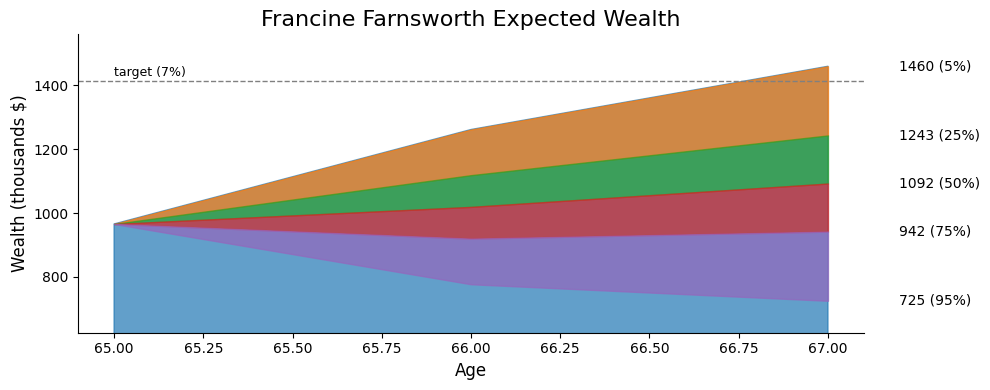

In [239]:
cumulative = confidence_bands.loc[name][cols]
cumulative.index += 1
cumulative.loc[clients.loc[name, 'Age'], cols] = investment_plan[(investment_plan.Name == name) & (investment_plan.Age == clients.loc[name, 'Age'])].W.item()
cumulative.sort_index(inplace=True)
target_chance = pct_reach_target.loc[name, 'Pct'].mul(100).astype(int).squeeze()

plt.figure(figsize=(10, 4))

colors = plt.cm.tab10.colors  # Choose a colormap for better visuals
last_x = cumulative.index[-1]
for i, col in enumerate(cumulative.columns):
    if i == 0:  # Bottom area
        plt.fill_between(cumulative.index, 0, cumulative[col], label=col, color=colors[i % len(colors)], alpha=0.7)
    else:  # Other stacked areas
        plt.fill_between(cumulative.index, cumulative.iloc[:, i - 1], cumulative[col], label=col, color=colors[i % len(colors)], alpha=0.7)

    # Position for the label
    last_x = cumulative.index[-1]
    last_y = cumulative.iloc[-1, i]  # Last value in the cumulative series
    
    plt.text(
        last_x + 0.2, last_y - 0.1,  # Slight offset for better visibility
        f"{last_y:.0f} ({col})",
        fontsize=10,
        # color=colors[i % len(colors)],
        va='center'
    )
    
plt.ylim(cumulative.min().min() - 100, cumulative.max().max() + 100) 
plt.axhline(y=target_wealth, color='gray', linestyle='--', linewidth=1)
plt.text(
    cumulative.index[0], target_wealth + 25,  # Slight offset for better visibility
    f"target ({target_chance}%)",
    fontsize=9,
    va='center'
)

ax = plt.gca()  # Get the current Axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and legend
plt.title(f'{name} Expected Wealth', fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Wealth (thousands $)", fontsize=12)
# plt.legend(title="Areas", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [240]:
investment_plan_fmt[investment_plan_fmt.Name == name]

,Name,Age,W,Mix,Return,Risk,E[W(t+1)],E[U]
52,Francine Farnsworth,65,965.7,1,5.54,15.25,1019.2,-6572.1
53,Francine Farnsworth,66,1035.0,1,5.54,15.25,1092.3,-5348.6


In [241]:
eg = result[(result.Age == 52) & (result.W == 513.6)]
mc = [f'Mix{i+1}' for i in range(8)]
eg.loc[:, mc] = eg['Exp_U_All_Mixes'].tolist()

fund_stats.index.name = 'Fund'

eg = eg.set_index(['Age', 'W'])[mc].stack().round(1)
eg.index.names = ['Age', 'W', 'Fund']
eg.name = 'E[U]'
eg = eg.to_frame().join(fund_stats).reset_index()
eg['W(t+1)'] = (eg.W * (1+eg.Return)).astype(float).round(1)
eg.loc[:, ['Risk', 'Return']] = eg[['Risk', 'Return']].astype(float).mul(100).round(2)

In [138]:
eg

,Age,W,Fund,E[U],Return,Risk,W(t+1)
0,52,513.6,Mix1,-13880.0,5.54,15.25,542.1
1,52,513.6,Mix2,-13911.4,5.13,13.5,540.0
2,52,513.6,Mix3,-13942.8,4.73,11.96,537.9
3,52,513.6,Mix4,-13974.3,4.33,10.47,535.8
4,52,513.6,Mix5,-14008.1,3.9,8.83,533.6
5,52,513.6,Mix6,-14040.5,3.48,7.31,531.5
6,52,513.6,Mix7,-14074.4,3.04,5.81,529.2
7,52,513.6,Mix8,-14114.0,2.54,4.4,526.6


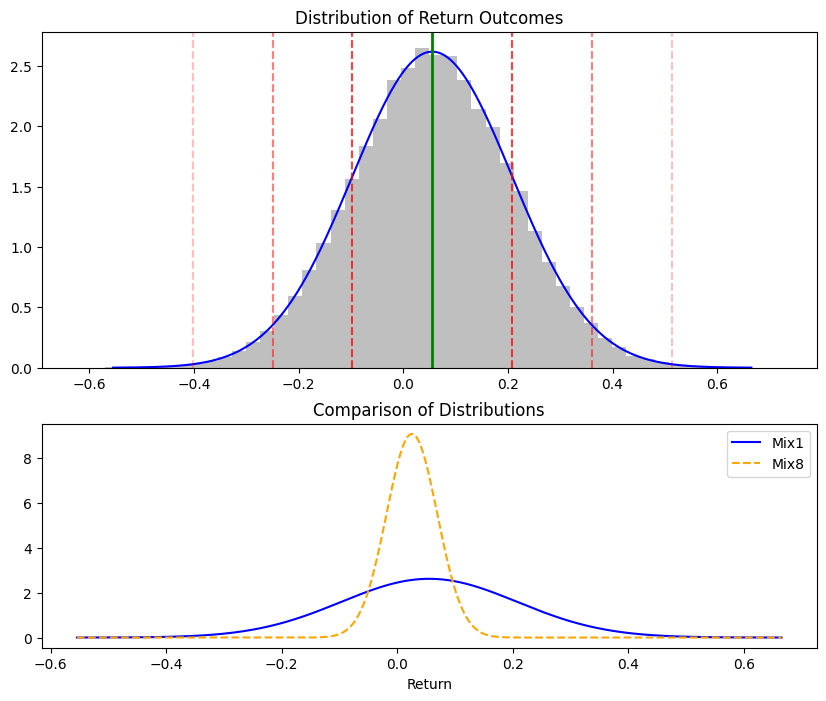

In [139]:
# Inputs
mean = fund_stats.loc['Mix1', 'Return']
std_dev = fund_stats.loc['Mix1', 'Risk']

mean2 = fund_stats.loc['Mix8', 'Return']
std_dev2 = fund_stats.loc['Mix8', 'Risk']

# Generate sample data
sample_size = 100000
data = np.random.normal(loc=mean, scale=std_dev, size=sample_size)

# Set the figure size
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 2]})

# Create a histogram of the data
axs[0].hist(data, bins=50, density=True, alpha=0.5, color='gray', label='Histogram')

# Generate the x values for the PDF line
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
pdf = norm.pdf(x, loc=mean, scale=std_dev)

# Plot the PDF
axs[0].plot(x, pdf, color='blue', label='PDF (Normal Curve)')


# Add a vertical green line for the center (mean)
axs[0].axvline(mean, color='green', linestyle='-', linewidth=2, label='Mean')

# Add vertical lines for 1, 2, and 3 standard deviations, getting lighter further from the mean
for i in range(1, 4):
    alpha = 1 - i * 0.25  # Reduce alpha for lighter lines
    axs[0].axvline(mean + i * std_dev, color='red', linestyle='--', alpha=alpha, label=f'+{i} Std Dev' if i == 1 else None)
    axs[0].axvline(mean - i * std_dev, color='red', linestyle='--', alpha=alpha, label=f'-{i} Std Dev' if i == 1 else None)

# Add labels, title, and legend
axs[0].set_title('Distribution of Return Outcomes')
# axs[0].set_xlabel('Return')
# axs[0].set_ylabel('Density')

# Bottom Plot: Comparison of two normal distributions
x2 = np.linspace(min(mean - 4*std_dev, mean2 - 4*std_dev2), 
                 max(mean + 4*std_dev, mean2 + 4*std_dev2), 
                 1000)

# PDF of the second distribution
pdf2 = norm.pdf(x2, loc=mean2, scale=std_dev2)
axs[1].plot(x, pdf, color='blue', label='Mix1')
axs[1].plot(x2, pdf2, color='orange', linestyle='--', label='Mix8')

axs[1].set_title('Comparison of Distributions')
axs[1].set_xlabel('Return')
axs[1].legend()

# Show the plot
plt.show()

Text(0.5, 0, 'Percent')

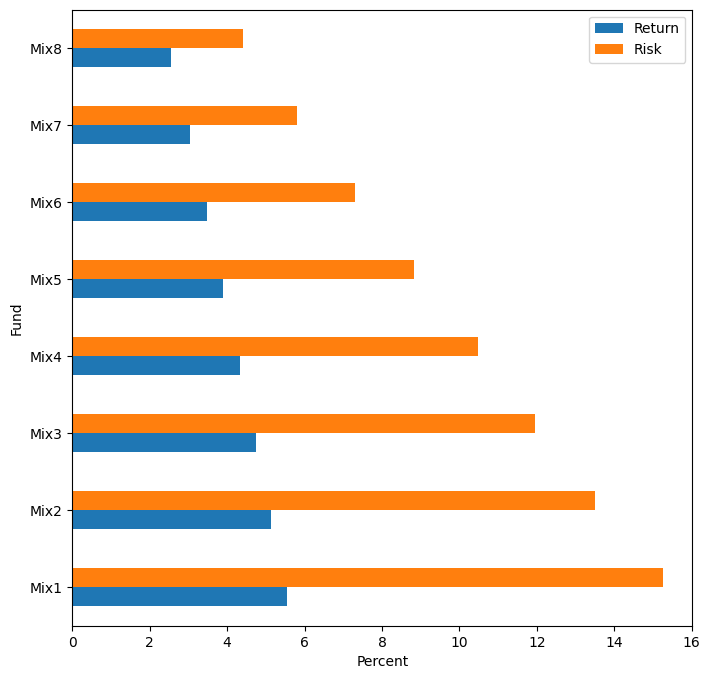

In [140]:
ax = fund_stats.mul(100).plot(kind='barh', figsize=(8, 8))
ax.set_xlabel('Percent')